In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance, ImageColor, ImageOps, ImageDraw

In [2]:
ITEM_SIZE = (20, 20)

# Combining with atlas

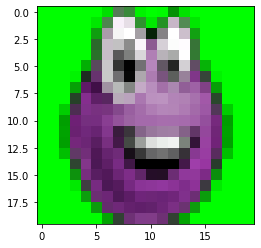

In [53]:
im_player = Image.open("Lazarus_stand.gif").convert("RGB")
im_player = im_player.crop((0,2,38,40))
im_player = im_player.resize(ITEM_SIZE)
plt.imshow(im_player)

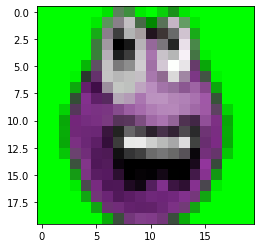

In [54]:
im_player_sq = Image.open("Lazarus_squished.gif").convert("RGB")
im_player_sq = im_player_sq.crop((0,2,38,40))
im_player_sq = im_player_sq.resize(ITEM_SIZE)
plt.imshow(im_player_sq)

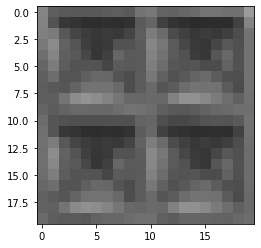

In [55]:
im_wall = Image.open("Wall.gif").convert("RGB")
im_wall = im_wall.crop((1,1,39,39))
im_wall = im_wall.resize(ITEM_SIZE)
plt.imshow(im_wall)

In [57]:
def get_box(file_name: str):
    im = Image.open(file_name).convert("RGB")
    im = im.crop((1,1,39,39))
    im = im.resize(ITEM_SIZE)        
    return im
im_stone = get_box("StoneBox.gif")
im_wood = get_box("WoodBox.gif")
im_rock = get_box("Rock.gif")
im_metal = get_box("MetalBox.gif")
im_card = get_box("CardBox.gif")
im_btn = get_box("Button.gif")

im_arr = [im_player, im_player_sq, im_wall, im_stone, im_wood, im_rock, im_metal, im_card, im_btn]

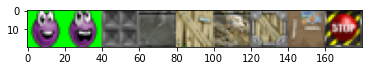

In [89]:
im_atlas = Image.new('RGB', (20*len(im_arr), 20), (0x00, 0xFF, 0x00))
for idx, im in enumerate(im_arr):
    im_atlas.paste(im, (20*idx, 0))
    
plt.imshow(im_atlas)

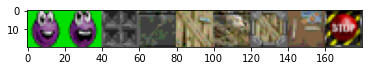

In [90]:
im_atlas = ImageOps.posterize(im_atlas, 3)

plt.imshow(im_atlas)

In [105]:
palette_raw = np.array([], dtype="int32")
atlas_bin = np.zeros(im_atlas.size[0]*im_atlas.size[1], dtype="int8")

def tohex(color_tuple):
    return (color_tuple[0]<<16) + (color_tuple[1]<<8) + (color_tuple[2])

for y in range(im_atlas.size[1]):
    for x in range(im_atlas.size[0]):
        color = tohex(im_atlas.getpixel((x,y)))
        found = np.where(palette_raw == color)[0]
        if len(found) != 0:
            atlas_bin[y*im_atlas.size[0] + x] = found[0]
        else:
            palette_raw = np.append(palette_raw, color)
            atlas_bin[y*im_atlas.size[0] + x] = len(palette_raw)-1
            
palette_raw, atlas_bin

(array([   57344,    49152,  4218944,  2129952,    32768,  4227136,
         8421504,  4210752,  6316128,  8421472, 10526880,  8429696,
         6324320,  6316064, 10518624, 10526816,  8421440,  6307872,
        10526848,  8413248,  6316096,  4210720,  2105376, 14737632,
        14729440, 12624064,  4218976,  2113568, 12624000,  8413280,
         6307904,  6324384,  6324352,  6316192,        0,  2105344,
         4210688, 10518688,     8192,    40960,  8413312, 10518656,
         2097152, 12632256,  4219008,  6316160,  8429728, 12607552,
        10518592,  6316032,  4194304,  6299648,  2121760,  8405120,
         8429760,  4202528, 12632064, 14737408,  6324224,  8388608,
        10485760, 12582912, 12591104,  6307840, 10510496, 14729408,
        14737600, 12615776,  8421536, 10518528,  6291456, 14688288,
        14696512, 12591136, 10526720,  6307936,  6299744, 10535104,
         8437952, 12615744,  8421376, 14704736, 14712960,  8413184,
            8224,  8396928,  6299776, 12632224, 

## Sanity check by reconstruction

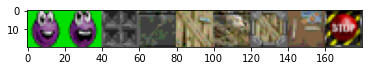

In [106]:
im_atlas_recon = Image.new('RGB', im_atlas.size, (0x00, 0xFF, 0x00))
for y in range(im_atlas.size[1]):
    for x in range(im_atlas.size[0]):
        im_atlas_recon.putpixel((x, y), num_to_hex(palette_raw[atlas_bin[y*im_atlas.size[0]+x]]))

plt.imshow(im_atlas_recon)

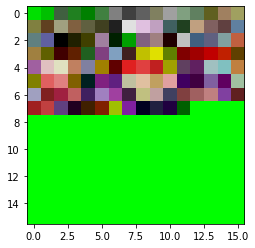

In [127]:
im_palette = Image.new('RGB', (16, 16), (0x00, 0xFF, 0x00))
for y in range(16):
    for x in range(16):
        if y*16+x < len(palette_raw):
            im_palette.putpixel((x, y), num_to_hex(palette_raw[y*16+x]))

plt.imshow(im_palette)

## Write to files

In [119]:
import struct
 
def write_rest(idx, file_name, payload):
    with open(file_name, "w+b") as f:
        for y in range(im_atlas.size[1]):
            pay = payload[y*im_atlas.size[0] + idx*20:y*im_atlas.size[0] + idx*20 + 20]
            print(f"Writing {pay} to {file_name}")
            f.write(pay)

In [108]:
# palette
with open("palette.b", "w+b") as f:
    for color in palette_raw:
        payload = struct.pack("I", color)
        f.write(payload)

In [123]:
names = ["player.b", "player_sq.b", "wall.b", "stone.b", "wood.b", "rock.b", "metal.b", "card.b", "btn.b"]

byte_arr = atlas_bin.tobytes()
for idx, name in enumerate(names):
    write_rest(idx, name, byte_arr)

Writing b'\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00\x00\x00\x05\x17\x18\x03\x00\x03\x19\x05\x00\x00\x00\x00\x00\x00' to player.b
Writing b"\x00\x00\x00\x00\x00\x04%\x17\x17%&\x06\x17\x19'\x00\x00\x00\x00\x00" to player.b
Writing b'\x00\x00\x00\x00\x004\x19+\x06\x175+\x17\x174\x00\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00\x004\x19\x07\x0c+@\n\n\x174\x00\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00\'\x07+\x16"\x08%K\x16+K\'\x00\x00\x00\x00' to player.b
Writing b'\x00\x00\x00\x00TL+\x08"\n@K\x07\x06U\x1b\x00\x00\x00\x00' to player.b
Writing b"\x00\x00\x00'[\\%\n\x06\x19%@%5]5\x04\x00\x00\x00" to player.b
Writing b'\x00\x00\x00\x1bUdd\n\n@%e%%@f\x1b\x00\x00\x00' to player.b
Writing b'\x00\x00\x01gVVL5n@@%%@@ng\x01\x00\x00' to player.b
Writing b'\x00\x00\x04LLVU5]@@@@@@5L\x04\x00\x00' to player.b
Writing b"\x00\x00'LLLUs\x16((]@(L5L'\x00\x00" to player.b
Writing b"\x00\x00'LL[V\\\x07\x06+